### 三、高斯混合模型

这是一种概率模型，假定实例是由多个参数位置的高斯分布的混合生成的。与单一分布模型不同，它可以对任意形状的数据进行建模，特别是处理多模态数据    
数学表示：假设数据由多个高斯分布的混合生成，即：

$P(x) = ∑(w_i * N(x | μ_i, Σ_i))$

其中，$w_i$ 是权重向量，$μ_i$ 是均值向量，$Σ_i$ 是协方差矩阵。

这个概率模型可以用来处理任意形状的数据，因为高斯分布可以处理任意形状的数据。

#### 1.核心优势  
软聚类：不同于K-means，软聚类算法允许对象属于多个聚类，并给出每个对象所属的聚类概率  
建模复杂形状：GMM可以拟合非常复杂的概率分布，这些分布无法用教科书式的单一分布来描述  


#### 2.EM算法  
由于GMM包含潜在变量，即我们观察不到每个数据点究竟是由哪一个高斯组件生成的。因此，无法直接使用简单的解析解来寻找最大似然估计  
概率密度函数：  
$$p(x|\theta)=\sum_{i=1}^K\pi_iN(x|\mu_i,\Sigma_i)$$

 E 步：根据当前参数计算每个样本属于每个高斯分布的后验概率   

 M 步：利用E步得到的厚颜概率，更新各分布的权重、均值和协方差，以最大化似然函数    

收敛性：通过并不断构造并优化对数似然函数的下界，保证模型最终能够收敛到局部最优解  

#### 3.核心参数与估计

核心参数：  
1) 均值向量；表示分布的中心位置  
2) 协方差矩阵；表示分布的形状和尺寸  
3) 权重：表示各个高斯分布的权重  

初始步骤：  
1) 随机生成均值向量、协方差矩阵和权重  
2) 创建一个空列表，用于存储生成的高斯分布  
3) 创建一个循环，迭代生成高斯分布  
4) 在循环中，生成一个高斯分布，并将其添加到列表中  
5) 返回生成的高斯分布列表  


#### 4.选择集群数  
超参数寻优过程中，不能利用轮廓系数来确定最优集群数。但是高斯混合模型无法使用该方法  
因为当集群不是球形或具有不同大小时，轮廓系数不适合  
应该使用贝叶斯信息准则和赤池信息准则  

$BIC = -2 * log(L) + log(n) * k  $  

$RIC = -2 * log(L) + log(n) * log(k)$

#### 5.GTZAN数据集实战  
该数据集包含了1000个歌曲样本    

包括pop,jaza,metal,rock,blues,classical,country,hiphop,reggae共10种不同的音乐类型    

本任务为了节省时间只随机抽取前100个样本进行训练  

由于不同音乐风格可能存在相似的特征，因此结果可能不如全样本训练的好

In [48]:

import os
import random
import numpy as np
import itertools  # 生成参数组合，适配进度条
import librosa
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
# 忽略无关警告
import warnings
warnings.filterwarnings('ignore')

AUDIO_FOLDER = r"C:\Users\23017\Desktop\Machine Learning\Unsupervised Learning\Clustering\lecture 6 Gaussian mixture\data"
SAMPLE_RATE = 22050             # 统一音频采样率（消除采样率差异）
N_MFCC = 13                     # MFCC特征维度（音频聚类经典值，无需修改）
SEED = 42                       # 全局随机种子（保证所有步骤结果可复现）
SELECT_NUM = 100                # 设定随机抽取样本数（目标100个）
SUPPORT_FORMATS = ('.wav',)     
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#F4A460']

# 固定所有随机种子
random.seed(SEED)
np.random.seed(SEED)

In [42]:
AUDIO_FOLDER = r"C:\Users\23017\Desktop\Machine Learning\Unsupervised Learning\Clustering\lecture 6 Gaussian mixture\data"  
SAMPLE_RATE = 22050             # 统一重采样率
N_MFCC = 13                     # MFCC特征维度
SEED = 42                       # 随机种子（保证结果可复现）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#F4A460']

In [49]:

all_valid_wav = []  # 存储所有有效WAV文件的完整路径
selected_audio = [] # 存储最终抽取的样本路径
audio_filenames = []# 存储抽取样本的纯文件名（可视化/结果输出用）
all_features = []   # 存储抽取样本的特征矩阵（时序帧 × 特征维度）

if not os.path.exists(AUDIO_FOLDER):
    raise FileNotFoundError(f"错误：音频目录 {AUDIO_FOLDER} 不存在，请检查路径！")

# 遍历目录，筛选纯WAV格式文件
for file in os.listdir(AUDIO_FOLDER):
    if file.lower().endswith(SUPPORT_FORMATS):
        file_path = os.path.join(AUDIO_FOLDER, file)
        all_valid_wav.append(file_path)

# 校验有效WAV数量
if len(all_valid_wav) == 0:
    raise ValueError(f"错误：目录 {AUDIO_FOLDER} 中无有效WAV文件！")
print(f" 目录中有效WAV文件总数：{len(all_valid_wav)} 个")


random.shuffle(all_valid_wav)  # 随机打乱，保证抽取随机性
selected_audio = all_valid_wav[:SELECT_NUM]
# selected_audio = all_valid_wav  # 抽取目录中所有WAV样本

print(f" 最终抽取样本数：{len(selected_audio)} 个（设定抽取{SELECT_NUM}个）")


print(f"\n 开始加载样本并提取特征...")
for file_path in tqdm(selected_audio, desc="样本加载进度", ncols=80, unit="个"):
    file = os.path.basename(file_path)  
    try:
        # 加载WAV音频：mono=True转单声道，sr统一采样率
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
        # 提取MFCC基础特征（n_mfcc=13，音频聚类经典维度）
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        # 一阶差分：捕捉特征的时间变化趋势
        mfcc_delta = librosa.feature.delta(mfcc)
        # 二阶差分：捕捉特征的变化率趋势
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        # 拼接特征并转置：格式转为「时序帧 × 特征维度」（符合机器学习输入要求）
        feats = np.vstack([mfcc, mfcc_delta, mfcc_delta2]).T
        # 保存特征和文件名
        all_features.append(feats)
        audio_filenames.append(file)
    except Exception as e:
        tqdm.write(f" 加载失败：{file} | 错误原因：{str(e)}（文件可能损坏）")


n_samples = len(audio_filenames)
if n_samples < 3:
    raise ValueError(f"错误：有效加载样本数为{n_samples}")
print(f"\n 样本加载完成 | 最终有效样本数：{n_samples} 个 | 单样本特征维度：{all_features[0].shape[1]}")

 目录中有效WAV文件总数：1000 个
 最终抽取样本数：100 个（设定抽取100个）

 开始加载样本并提取特征...


样本加载进度: 100%|███████████████████████████| 100/100 [00:02<00:00, 34.42个/s]


 样本加载完成 | 最终有效样本数：100 个 | 单样本特征维度：39


In [50]:

# 拼接所有样本特征，拟合标准化器（保证标准化尺度统一）
all_feats_combined = np.vstack(all_features)
scaler = StandardScaler()
scaler.fit(all_feats_combined)
# 对每个样本单独标准化（保留时序结构）
all_feats_scaled = [scaler.transform(feats) for feats in all_features]


audio_embeddings = []  # GMM最终输入：n_samples × 固定特征数
for feats in all_feats_scaled:
    # 用「时序维度的均值+标准差」压缩：兼顾集中趋势和离散程度，比仅用均值更鲁棒
    feat_mean = np.mean(feats, axis=0)
    feat_std = np.std(feats, axis=0)
    embedding = np.hstack([feat_mean, feat_std])  # 拼接为固定长度向量
    audio_embeddings.append(embedding)
# 转换为numpy矩阵
audio_embeddings = np.array(audio_embeddings)

print(f" 特征预处理完成 | GMM输入矩阵维度：{audio_embeddings.shape}（样本数 × 固定特征数）")

 特征预处理完成 | GMM输入矩阵维度：(100, 78)（样本数 × 固定特征数）


In [ ]:

param_grid = {
    'n_components': range(2, min(10, n_samples)),  # 簇数：2~9（或样本数-1，避免过拟合）
    'covariance_type': ['full', 'tied', 'diag'],   # 协方差类型：拟合能力从强到弱
    'n_init': [5, 10]                              # 初始化次数：避免EM算法陷入局部最优
}

param_combinations = list(itertools.product(
    param_grid['n_components'],
    param_grid['covariance_type'],
    param_grid['n_init']
))
print(f"\n开始GMM超参数寻优 | 总参数组合数：{len(param_combinations)} | 评估指标：BIC/AIC（值越小越优）")


best_bic = float('inf')    # 最优BIC值（初始无穷大）
best_aic = float('inf')    # 最优AIC值
best_params = None         # 存储最优超参数组合
all_tuning_results = []    # 存储所有组合结果（可视化簇数-BIC/AIC曲线用）


for n_comp, cov_type, n_init in tqdm(param_combinations, desc="参数验证进度", ncols=80, unit="组"):
    cv_bic = []  # 存储该组合的交叉验证BIC值
    cv_aic = []  # 存储该组合的交叉验证AIC值
    # 执行留一交叉验证
    for train_idx, test_idx in loo.split(audio_embeddings):
        X_train = audio_embeddings[train_idx]
        # 跳过训练样本数 < 簇数的情况
        if len(X_train) < n_comp:
            continue
        # 初始化GMM模型
        gmm = GaussianMixture(
            n_components=n_comp,
            covariance_type=cov_type,
            n_init=n_init,
            max_iter=500,  # 保证EM算法充分收敛
            random_state=SEED
        )
        # 拟合训练集
        gmm.fit(X_train)
        cv_bic.append(gmm.bic(X_train))
        cv_aic.append(gmm.aic(X_train))
    # 计算平均BIC/AIC，仅保留有效验证结果
    if cv_bic and cv_aic:
        mean_bic = np.mean(cv_bic)
        mean_aic = np.mean(cv_aic)
        # 保存结果
        all_tuning_results.append({
            'n_comp': n_comp,
            'cov_type': cov_type,
            'n_init': n_init,
            'mean_bic': mean_bic,
            'mean_aic': mean_aic
        })
        # 打印最优候选结果（不打断进度条）
        if mean_bic < best_bic:
            tqdm.write(f" 发现更优模型 | 簇数={n_comp} | 协方差={cov_type} | BIC={mean_bic:.2f}")
            # 更新最优参数（优先BIC最优）
            best_bic = mean_bic
            best_aic = mean_aic
            best_params = {
                'n_components': n_comp,
                'covariance_type': cov_type,
                'n_init': n_init,
                'best_bic': round(best_bic, 2),
                'best_aic': round(best_aic, 2)
            }

if best_params is None:
    raise ValueError("超参数寻优失败，请检查样本量（最少3个有效样本）或参数候选集！")
print(f"\n GMM超参数寻优完成（BIC最优）")
for k, v in best_params.items():
    print(f"  {k:<20} : {v}")
optimal_n_comp = best_params['n_components']  # 提取最优簇数，后续聚类用


开始GMM超参数寻优 | 总参数组合数：48 | 评估指标：BIC/AIC（值越小越优）


参数验证进度:   2%|▋                             | 1/48 [00:05<04:17,  5.48s/组]       

✨ 发现更优模型 | 簇数=2 | 协方差=full | BIC=-15439.02


参数验证进度:  10%|███▏                          | 5/48 [00:28<03:44,  5.22s/组]       

✨ 发现更优模型 | 簇数=2 | 协方差=diag | BIC=-17239.40


参数验证进度:  12%|███▊                          | 6/48 [00:35<04:08,  5.92s/组]       

✨ 发现更优模型 | 簇数=2 | 协方差=diag | BIC=-17272.25


参数验证进度:  23%|██████▋                      | 11/48 [01:05<03:21,  5.45s/组]       

✨ 发现更优模型 | 簇数=3 | 协方差=diag | BIC=-17484.15


参数验证进度:  25%|███████▎                     | 12/48 [01:12<03:30,  5.84s/组]       

✨ 发现更优模型 | 簇数=3 | 协方差=diag | BIC=-17515.68


参数验证进度: 100%|█████████████████████████████| 48/48 [07:13<00:00,  9.03s/组]


 GMM超参数寻优完成（BIC最优）
  n_components         : 3
  covariance_type      : diag
  n_init               : 10
  best_bic             : -17515.68
  best_aic             : -18735.38


In [52]:

gmm_final = GaussianMixture(
    n_components=optimal_n_comp,
    covariance_type=best_params['covariance_type'],
    n_init=best_params['n_init'],
    max_iter=500,
    random_state=SEED
)
# 用全部样本训练模型
gmm_final.fit(audio_embeddings)


cluster_labels = gmm_final.predict(audio_embeddings)  # 每个样本的聚类标签
cluster_probs = gmm_final.predict_proba(audio_embeddings)  # 每个样本属于各簇的概率
cluster_conf = np.max(cluster_probs, axis=1)  # 聚类置信度（最大概率）


print(f" GMM聚类完成 | 聚类标签范围：0~{optimal_n_comp-1}")
for c in range(optimal_n_comp):
    c_count = np.sum(cluster_labels == c)
    c_conf_mean = np.mean(cluster_conf[cluster_labels == c])
    print(f"  簇{c} | 样本数：{c_count} 个 | 平均置信度：{c_conf_mean:.4f}")

 GMM聚类完成 | 聚类标签范围：0~2
  簇0 | 样本数：39 个 | 平均置信度：1.0000
  簇1 | 样本数：17 个 | 平均置信度：0.9999
  簇2 | 样本数：44 个 | 平均置信度：0.9960


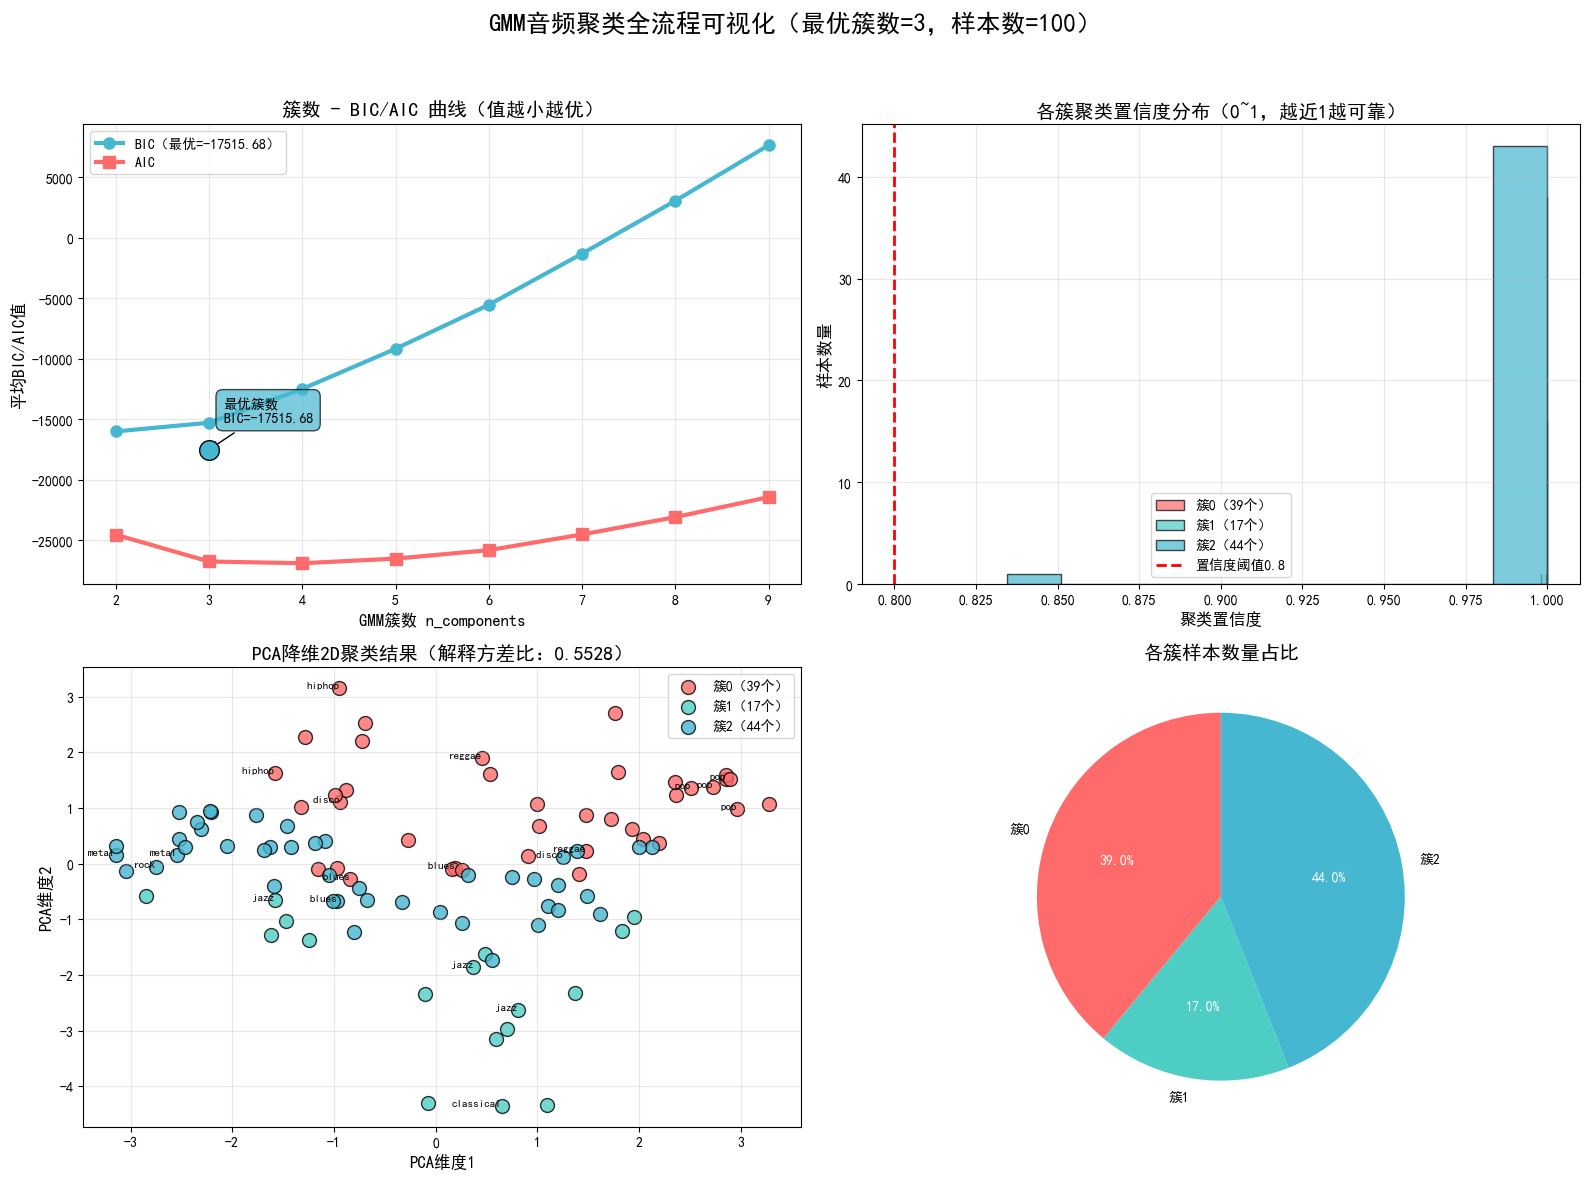

In [ ]:

n_comp_list = [r['n_comp'] for r in all_tuning_results]
bic_list = [r['mean_bic'] for r in all_tuning_results]
aic_list = [r['mean_aic'] for r in all_tuning_results]
# 按簇数分组计算平均BIC/AIC（避免重复）
n_comp_unique = sorted(list(set(n_comp_list)))
bic_mean = [np.mean([b for n, b in zip(n_comp_list, bic_list) if n == c]) for c in n_comp_unique]
aic_mean = [np.mean([a for n, a in zip(n_comp_list, aic_list) if n == c]) for c in n_comp_unique]


fig = plt.figure(figsize=(16, 12))
plt.suptitle(f'GMM音频聚类全流程可视化（最优簇数={optimal_n_comp}，样本数={n_samples}）', 
             fontsize=18, fontweight='bold', y=0.98)


ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(n_comp_unique, bic_mean, 'o-', linewidth=3, markersize=8, color='#45B7D1', 
         label=f'BIC（最优={best_params["best_bic"]}）')
ax1.plot(n_comp_unique, aic_mean, 's-', linewidth=3, markersize=8, color='#FF6B6B', label='AIC')
# 标注最优簇数
ax1.scatter(optimal_n_comp, best_params['best_bic'], s=200, color='#45B7D1', 
            edgecolors='black', zorder=10)
ax1.annotate(f'最优簇数\nBIC={best_params["best_bic"]}',
             xy=(optimal_n_comp, best_params['best_bic']),
             xytext=(10, 20), textcoords='offset points', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#45B7D1', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax1.set_title('簇数 - BIC/AIC 曲线（值越小越优）', fontsize=14, fontweight='bold')
ax1.set_xlabel('GMM簇数 n_components', fontsize=12)
ax1.set_ylabel('平均BIC/AIC值', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(n_comp_unique)


ax2 = fig.add_subplot(2, 2, 2)
for c in range(optimal_n_comp):
    c_conf = cluster_conf[cluster_labels == c]
    ax2.hist(c_conf, bins=10, alpha=0.7, label=f'簇{c}（{len(c_conf)}个）',
             color=COLORS[c], edgecolor='black')
ax2.axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='置信度阈值0.8')
ax2.set_title('各簇聚类置信度分布（0~1，越近1越可靠）', fontsize=14, fontweight='bold')
ax2.set_xlabel('聚类置信度', fontsize=12)
ax2.set_ylabel('样本数量', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)


ax3 = fig.add_subplot(2, 2, 3)
pca = PCA(n_components=2, random_state=SEED)
embeddings_2d = pca.fit_transform(audio_embeddings)
# 绘制每个簇的散点
for c in range(optimal_n_comp):
    mask = cluster_labels == c
    ax3.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                label=f'簇{c}（{np.sum(mask)}个）', s=100, alpha=0.8,
                color=COLORS[c], edgecolors='black', marker='o')
# 标注部分样本名
for i in range(min(20, n_samples)):
    ax3.annotate(audio_filenames[i].split('.')[0],
                 (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                 fontsize=8, ha='right')
ax3.set_title(f'PCA降维2D聚类结果（解释方差比：{pca.explained_variance_ratio_.sum():.4f}）', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('PCA维度1', fontsize=12)
ax3.set_ylabel('PCA维度2', fontsize=12)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)


ax4 = fig.add_subplot(2, 2, 4)
c_counts = [np.sum(cluster_labels == c) for c in range(optimal_n_comp)]
wedges, texts, autotexts = ax4.pie(c_counts, labels=[f'簇{c}' for c in range(optimal_n_comp)],
                                    colors=COLORS[:optimal_n_comp], autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 10})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax4.set_title('各簇样本数量占比', fontsize=14, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.95])  # 适配总标题
save_path = os.path.join(AUDIO_FOLDER, 'GMM音频聚类可视化结果.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # 300DPI高清保存
plt.show()


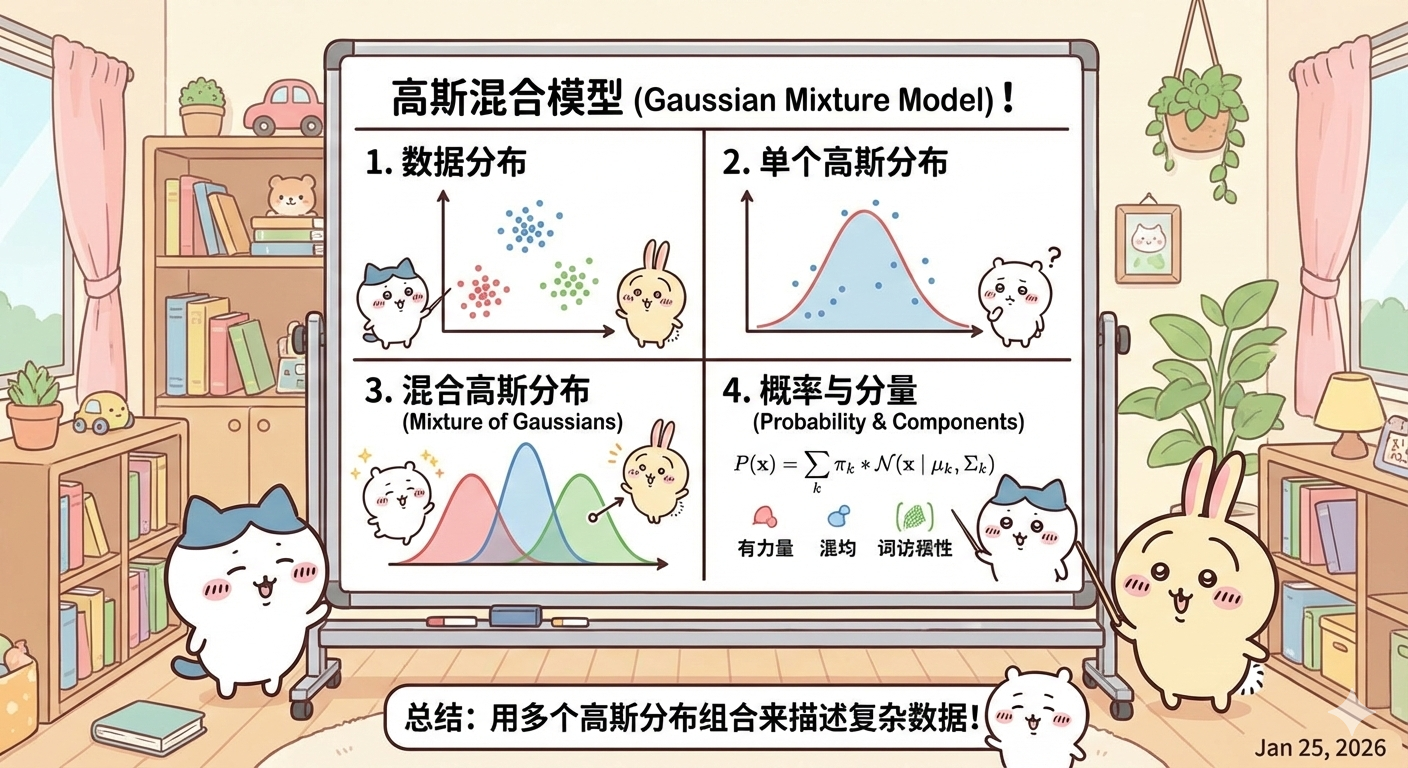

### 总结  
聚类算法主要是识别相似实例并将其分配给相似实例的集群或组  

在聚类算法中，主要介绍了K-means，DBScan，GMM，三种算法  
1. K-means  
K-means算法是机器学习领域最常用的无监督学习算法，K-means算法的基本思路是：  
1.1. 随机选择K个样本作为初始聚类中心  （轮廓系数）
1.2. 计算样本到聚类中心的距离，将样本分配给距离最近的聚类中心  
1.3. 重新计算聚类中心  
1.4. 重复1.2和1.3步骤，直到聚类中心不再变化或者达到最大迭代次数  
2. DBSCAN  
  DBSCAN算法是机器学习领域最常用的无监督学习算法，DBSCAN算法的基本思路是：  
2.1. 确定eps和minPts参数  
2.2. 找到eps邻域内的样本点  
2.3. 找到核心对象  
2.4. 找到边界对象  
2.5. 找到噪声对象  
2.6. 构建聚类  
3. 高斯混合模型  
  高斯混合模型（Gaussian Mixture Model，GMM）是一种常用的无监督学习算法，GMM的基本思路是：  
3.1. 确定参数  
3.2. 构建模型  
3.3. 预测  
3.4. 评估  
3.5. 优化参数  （BIC/AIC准则）
3.6. 构建聚类   

在最后高斯混合模型的可视化中，利用PCA算法将特征降低到2维。PCA就是后文介绍的降维算法中最常用的一种

